In [65]:
import sys
import os
from pathlib import Path
import pandas as pd
import sys

import os
from pathlib import Path
parent_dir = os.path.dirname(os.getcwd())
sys.path.append(parent_dir)
processed_series_path = Path(parent_dir) / 'processed_series'
generated_series_path = Path(parent_dir) / 'generated_series'
figure_save_path = Path('.') / 'figures'
if not figure_save_path.exists():
    os.makedirs(figure_save_path)

import copy
from scipy.special import erf
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
import pickle
from models.ICL import MultiResolutionPDF
import sys
import torch

import torch.nn as nn
import torch.optim as optim

from tqdm import tqdm
sys.path.append("../models")

In [2]:
generated_series_path = Path('.') / 'generated_series'
generated_series_files = sorted([path for path in generated_series_path.iterdir()], key=lambda x: x.name)


In [3]:
# for i, name in enumerate(generated_series_files):
#     print(f"[{i}] {name}")
    
with open(generated_series_files[199], 'rb') as file:
    series_dict = pickle.load(file)



In [42]:

class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, output_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)  # Third layer
        self.fc4 = nn.Linear(hidden_size3, output_size)  # Adjusted final layer
        self.activation = nn.LeakyReLU()  # Shared activation function
        
    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc3(x))
        output = self.fc4(x)  # Note: No activation after the last layer if it's meant for a classification output layer
        return output

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available. Using GPU.")
else:
    device = torch.device("cpu")
    print("CUDA is not available. Using CPU.")
    

def NN_AR1_with_sigma(model, time_series, epochs=100, lr=0.001, patience=10):
    # time_series = np.asarray(time_series, dtype=np.float32)
    X_tensor = time_series[:-1].reshape(-1, 1)
    Y_tensor = time_series[1:].reshape(-1)  
    print(X_tensor.shape)
    # Loss and optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr)
    best_loss = float('inf')
    epochs_no_improve = 0
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        # Forward pass
        outputs = model(X_tensor)
        mu, log_sigma = outputs[:, 0], outputs[:, 1]
        sigma = torch.exp(log_sigma)
        # Negative log likelihood
        loss = torch.mean(log_sigma + 0.5 * ((Y_tensor - mu) ** 2) / sigma**2)
        # loss = torch.mean((Y_tensor - mu) ** 2) 
        loss.backward()
        optimizer.step()
        
        # Check for early stopping
        if loss < best_loss:
            best_loss = loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve == patience:
                # print(f'Early stop at epoch {epoch+1}')
                break
            
        if (epoch+1) % 10 == 0:            
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')
    
    # Predict the next state
    model.eval()
    with torch.no_grad():
        last_x = time_series[-1].reshape(-1, 1)
        pred = model(last_x)
        mu, log_sigma = pred[0][0].item(), pred[0][1].item()
        sigma = np.exp(log_sigma)
    
    return mu, sigma

CUDA is available. Using GPU.


/tmp/ipykernel_712605/3834413996.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  time_series = torch.tensor(time_series, dtype=torch.float32).to(device)


In [87]:
cutoff = 3
time_series = series_dict['time_series']
model = SimpleNN(input_size=1, hidden_size1=64, hidden_size2=32, hidden_size3=16, output_size=2).to(device)

time_series = torch.tensor(time_series, dtype=torch.float32).to(device)
time_series = time_series[:cutoff]
NN_AR1_with_sigma(model, time_series[:cutoff], epochs=1000, lr=0.001, patience=30)

torch.Size([2, 1])
Epoch [10/1000], Loss: -0.1947
Epoch [20/1000], Loss: -0.4278
Epoch [30/1000], Loss: -0.8297
Epoch [40/1000], Loss: -1.2801
Epoch [50/1000], Loss: -1.8023
Epoch [60/1000], Loss: -2.7397
Epoch [70/1000], Loss: -3.4832
Epoch [80/1000], Loss: -4.0198
Epoch [90/1000], Loss: -3.8817
Epoch [100/1000], Loss: -4.4558
Epoch [110/1000], Loss: -4.6289
Epoch [120/1000], Loss: -4.2932
Epoch [130/1000], Loss: -4.9452
Epoch [140/1000], Loss: -5.0689
Epoch [150/1000], Loss: -3.7730
Epoch [160/1000], Loss: -4.7486
Epoch [170/1000], Loss: -5.1113
Epoch [180/1000], Loss: -4.5459
Epoch [190/1000], Loss: -4.1010
Epoch [200/1000], Loss: -4.9131


(0.3173673152923584, 0.009059785144329176)

In [88]:
model.eval()
# input = torch.tensor(time_series[:-1], dtype=torch.float32).reshape(-1,1)
input = torch.tensor(np.linspace(0,1,20), dtype=torch.float32).reshape(-1,1).to(device)
output = model(input).cpu().detach().numpy()
mu = output[:,0]
log_sigma = output[:,1]
sigma = np.exp(log_sigma)
sigma_up = mu + 2 * sigma
sigma_down = mu - 2 * sigma

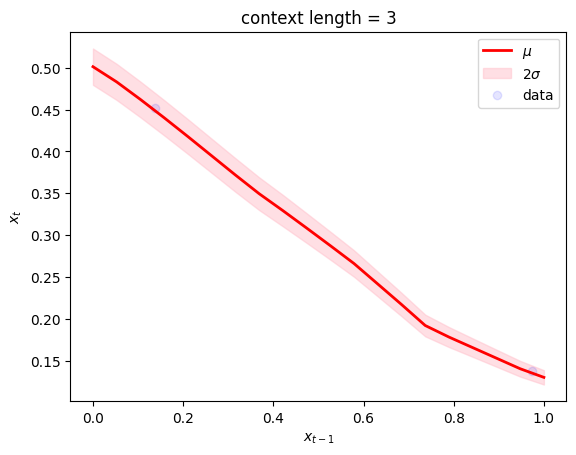

In [89]:

plt.plot(input.cpu(),mu, lw = 2, c = 'red', label = r"$\mu$")
plt.fill_between(input.cpu().numpy().flatten(), sigma_down, sigma_up, color='pink', alpha=0.5, label=r'$2 \sigma$')

plt.scatter(time_series[:-1].cpu(),time_series[1:].cpu(), alpha = 0.1, c = 'blue', label = "data")
plt.legend()
plt.title(f'context length = {cutoff}')
plt.xlabel(r'$x_{t-1}$')
plt.ylabel(r'$x_t$')

plt.savefig(figure_save_path / f"neural_net_AR1_{cutoff}.png", dpi=300, bbox_inches='tight')


In [90]:
r = 3.9
sigma_val = 0.0136
### Logistic Map
def logistic_map(r, x):
    return r * x * (1 - x)

### Manual differentiation

def logistic_map_diff(r, x):
    return np.abs(r * (1-2*x))

In [91]:
input = np.linspace(0,1,20)

mu = logistic_map(r, input)
sigma = logistic_map_diff(r, input) * sigma_val
sigma_up = mu + 2 * sigma
sigma_down = mu - 2 * sigma

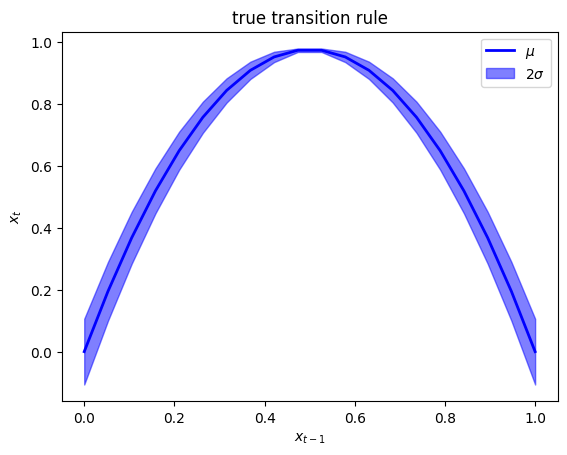

In [92]:

plt.plot(input,mu, lw = 2, c = 'blue', label = r"$\mu$")
plt.fill_between(input, sigma_down, sigma_up, color='blue', alpha=0.5, label=r'$2 \sigma$')
plt.legend()
plt.title(f'true transition rule')
plt.xlabel(r'$x_{t-1}$')
plt.ylabel(r'$x_t$')

plt.savefig(figure_save_path / f"true_transition_rule.png", dpi=300, bbox_inches='tight')
